## 1. Configuration

Set `EMB_PRECOMPUTED = True` in `constants.py` to load precomputed embeddings and skip the generation step.

In [1]:
# Usage Note
# -----------
# Generates all embeddings at runtime if False (very slow)
# Embeddings are saved to: data > ready > data_with_embeddings.npz
# Once you have the embeddings saved, set this to True to load them directly
EMB_PRECOMPUTED = True

## 2. Setup and Imports

In [ ]:
from constants import EMBEDDINGS_PATH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

c:\Users\willi\OneDrive\Masters - McGill\McGill - Term 1 - Fall 2025\COMP 545 - NLP\Project\Embeddings for risk prediction (545)\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 11.8


## 3. Data Loading and Preparation

We load the same dataset and use **identical train/test split** (random_state=42) as the benchmark model for fair comparison.

In [ ]:
from constants import DATASET_PATH
df = pd.read_csv(DATASET_PATH)
df.head()

,gvkey,year_month,risk_factors_text,management_text,std_dev,realized_drawdown
0,5560.0,2005-08,"item 1 risk factors form 10- k, amended form 1...",item 2 management s discussion analysis financ...,0.243191,-0.230594
1,9325.0,2005-08,item 1- risk factors.,item 2. management' s discussion analysis fina...,0.302114,-0.097688
2,12141.0,2005-08,item 1 risk factors challenges business model ...,item 7. management s discussion analysis finan...,0.160802,-0.189479
3,61567.0,2005-09,item 1a. risk factors 12 item 1a. risk factors...,item 7. management s discussion analysis finan...,0.247901,-0.099658
4,14824.0,2005-11,item 1a risk factors 39 item 1a. risk factors ...,item 2 management s discussion analysis financ...,0.092929,-0.068840


In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nCombining risk_factors_text and management_text...")
df["combined_text"] = df["risk_factors_text"].fillna("") + " " + df["management_text"].fillna("")

print(f"\nMissing risk_factors_text: {df["risk_factors_text"].isna().sum()} ({df["risk_factors_text"].isna().sum()/len(df)*100:.2f}%)")
print(f"Missing management_text: {df["management_text"].isna().sum()} ({df["management_text"].isna().sum()/len(df)*100:.2f}%)")
print(f"Empty combined_text (both empty): {(df["combined_text"].str.strip() == "").sum()} ({(df["combined_text"].str.strip() == "").sum()/len(df)*100:.2f}%)")

df_clean = df[df["combined_text"].str.strip() != ""].reset_index(drop=True)
print(f"\nDataset after removing empty text: {df_clean.shape}")

print(f"\nSample combined text length (chars): {df_clean["combined_text"].str.len().mean():.0f} +/- {df_clean["combined_text"].str.len().std():.0f}")
df_clean.head()

Dataset shape: (227634, 6)

Columns: ['gvkey', 'year_month', 'risk_factors_text', 'management_text', 'std_dev', 'realized_drawdown']

Combining risk_factors_text and management_text...

Missing risk_factors_text: 0 (0.00%)
Missing management_text: 0 (0.00%)
Empty combined_text (both empty): 0 (0.00%)

Missing risk_factors_text: 0 (0.00%)
Missing management_text: 0 (0.00%)
Empty combined_text (both empty): 0 (0.00%)

Dataset after removing empty text: (227634, 7)

Sample combined text length (chars): 10044 +/- 4621

Dataset after removing empty text: (227634, 7)

Sample combined text length (chars): 10044 +/- 4621


,gvkey,year_month,risk_factors_text,management_text,std_dev,realized_drawdown,combined_text
0,5560.0,2005-08,"item 1 risk factors form 10- k, amended form 1...",item 2 management s discussion analysis financ...,0.243191,-0.230594,"item 1 risk factors form 10- k, amended form 1..."
1,9325.0,2005-08,item 1- risk factors.,item 2. management' s discussion analysis fina...,0.302114,-0.097688,item 1- risk factors. item 2. management' s di...
2,12141.0,2005-08,item 1 risk factors challenges business model ...,item 7. management s discussion analysis finan...,0.160802,-0.189479,item 1 risk factors challenges business model ...
3,61567.0,2005-09,item 1a. risk factors 12 item 1a. risk factors...,item 7. management s discussion analysis finan...,0.247901,-0.099658,item 1a. risk factors 12 item 1a. risk factors...
4,14824.0,2005-11,item 1a risk factors 39 item 1a. risk factors ...,item 2 management s discussion analysis financ...,0.092929,-0.068840,item 1a risk factors 39 item 1a. risk factors ...


In [ ]:
y = df_clean["realized_drawdown"].values

train_idx, test_idx = train_test_split(
    np.arange(len(df_clean)), 
    test_size=0.2, 
    random_state=42
)

y_train = y[train_idx]
y_test = y[test_idx]
text_train = df_clean.iloc[train_idx]["combined_text"].tolist()
text_test = df_clean.iloc[test_idx]["combined_text"].tolist()

print(f"Training set size: {len(train_idx)} samples")
print(f"Test set size: {len(test_idx)} samples")
print(f"\nSample text length (chars): {np.mean([len(t) for t in text_train]):.0f} +/- {np.std([len(t) for t in text_train]):.0f}")

Training set size: 182107 samples
Test set size: 45527 samples

Sample text length (chars): 10054 +/- 4623

Sample text length (chars): 10054 +/- 4623


## 4. FinBERT Embedding Generation or Loading

**Two modes:**
1. **EMB_PRECOMPUTED = False**: Generate embeddings from text and save for future use
2. **EMB_PRECOMPUTED = True**: Load precomputed embeddings

In [ ]:
if EMB_PRECOMPUTED:
    print("="*60)
    print("LOADING PRECOMPUTED EMBEDDINGS")
    print("="*60)
    
    embeddings_data = np.load(EMBEDDINGS_PATH)
    X_train_embeddings = embeddings_data["train_embeddings"]
    X_test_embeddings = embeddings_data["test_embeddings"]
    loaded_train_idx = embeddings_data["train_indices"]
    loaded_test_idx = embeddings_data["test_indices"]
    
    if not (np.array_equal(loaded_train_idx, train_idx) and np.array_equal(loaded_test_idx, test_idx)):
        print()
        print("WARNING: Loaded indices don't match current split!")
        print("   This may happen if you changed the dataset or random seed.")
        print("   Set EMB_PRECOMPUTED = False to regenerate embeddings.")
        raise ValueError("Index mismatch detected")
    
    print(f"\nLoaded training embeddings: {X_train_embeddings.shape}")
    print(f"Loaded test embeddings: {X_test_embeddings.shape}")
    print(f"Verified indices match current split")
    print("="*60)
    
else:
    print("="*60)
    print("GENERATING EMBEDDINGS FROM SCRATCH")
    print("="*60)
    

    print("Loading FinBERT model...")
    model_name = "ProsusAI/finbert"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    finbert_model = AutoModel.from_pretrained(model_name)
    finbert_model.to(device)
    finbert_model.eval()
    print("FinBERT loaded successfully!\n")
    

    def generate_embeddings(texts, model, tokenizer, batch_size=16, max_length=512):
        embeddings = []
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
                batch_texts = texts[i:i+batch_size]
                
                encoded = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors="pt"
                )
                
                encoded = {k: v.to(device) for k, v in encoded.items()}
                
                outputs = model(**encoded)
                
                attention_mask = encoded["attention_mask"]
                token_embeddings = outputs.last_hidden_state
                
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                mean_embeddings = sum_embeddings / sum_mask
                
                embeddings.append(mean_embeddings.cpu().numpy())
        
        return np.vstack(embeddings)
    
    print("Generating training embeddings...")
    X_train_embeddings = generate_embeddings(text_train, finbert_model, tokenizer, batch_size=16)
    
    print("\nGenerating test embeddings...")
    X_test_embeddings = generate_embeddings(text_test, finbert_model, tokenizer, batch_size=16)
    
    # Free up GPU memory
    del finbert_model
    torch.cuda.empty_cache()
    
    print("\n" + "="*60)
    print("SAVING EMBEDDINGS FOR FUTURE USE")
    print("="*60)
    
    np.savez_compressed(
        EMBEDDINGS_PATH,
        train_embeddings=X_train_embeddings,
        test_embeddings=X_test_embeddings,
        train_indices=train_idx,
        test_indices=test_idx
    )
    
    print(f"Saved embeddings to: {EMBEDDINGS_PATH}")
    print("="*60)

LOADING PRECOMPUTED EMBEDDINGS

Loaded training embeddings: (182107, 768)
Loaded test embeddings: (45527, 768)
Verified indices match current split

Loaded training embeddings: (182107, 768)
Loaded test embeddings: (45527, 768)
Verified indices match current split


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

print(f"Scaled training embeddings shape: {X_train_scaled.shape}")
print(f"Scaled test embeddings shape: {X_test_scaled.shape}")

Scaled training embeddings shape: (182107, 768)
Scaled test embeddings shape: (45527, 768)


## 5. Model 1: FinBERT + Linear Regression

We use Ridge Regression (L2 regularization) to prevent overfitting on the 768-dimensional embeddings. Hyperparameter search over regularization strength (alpha).

In [ ]:
ridge_params = {
    "alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

print("Starting Ridge Regression hyperparameter search...")
ridge_search = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

ridge_search.fit(X_train_scaled, y_train)

print()
print(f"Best parameters: {ridge_search.best_params_}")
print(f"Best CV R2 score: {ridge_search.best_score_:.6f}")

best_ridge = ridge_search.best_estimator_

Starting Ridge Regression hyperparameter search...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Best parameters: {'alpha': 100.0}
Best CV R2 score: 0.179511

Best parameters: {'alpha': 100.0}
Best CV R2 score: 0.179511


In [ ]:
y_train_pred_ridge = best_ridge.predict(X_train_scaled)
y_test_pred_ridge = best_ridge.predict(X_test_scaled)


ridge_train_r2 = r2_score(y_train, y_train_pred_ridge)
ridge_test_r2 = r2_score(y_test, y_test_pred_ridge)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_test_mae = mean_absolute_error(y_test, y_test_pred_ridge)

print()
print("="*50)
print("FinBERT + Ridge Regression Performance")
print("="*50)
print(f"\nTraining Set:")
print(f"  R2 Score:  {ridge_train_r2:.6f}")
print(f"  RMSE:      {ridge_train_rmse:.6f}")
print(f"  MAE:       {ridge_train_mae:.6f}")

print(f"\nTest Set:")
print(f"  R2 Score:  {ridge_test_r2:.6f}")
print(f"  RMSE:      {ridge_test_rmse:.6f}")
print(f"  MAE:       {ridge_test_mae:.6f}")


FinBERT + Ridge Regression Performance

Training Set:
  R2 Score:  0.187431
  RMSE:      0.195357
  MAE:       0.154514

Test Set:
  R2 Score:  0.180441
  RMSE:      0.196955
  MAE:       0.155807


## 6. Model 2: FinBERT + LightGBM

LightGBM can capture non-linear relationships in the embedding space. We use GPU acceleration and perform randomized search over key hyperparameters.

In [ ]:
lgb_params = {
    "num_leaves":        [15, 31],
    "max_depth":         [3, 5, 7, 10],
    "learning_rate":     [0.01, 0.05, 0.1],
    "n_estimators":      [100, 200],
    "min_child_samples": [50, 100],
    "subsample":         [0.7, 0.8],
    "colsample_bytree":  [0.7, 0.8],
    "reg_alpha":         [0.1, 0.5, 1.0],
    "reg_lambda":        [0.1, 0.5, 1.0]
}

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    device='gpu' if torch.cuda.is_available() else 'cpu',
    gpu_use_dp=True,
    random_state=42,
    verbose=-1,
    early_stopping_rounds=50,  
)

print("Starting LightGBM hyperparameter search...")
lgb_search = RandomizedSearchCV(
    lgb_model,
    lgb_params,
    n_iter=25,
    cv=3,
    scoring='r2',
    n_jobs=1,
    random_state=42,
    verbose=2
)

lgb_search.fit(
    X_train_embeddings,
    y_train,
    eval_set=[(X_test_embeddings, y_test)],
)  

print(f"\nBest parameters: {lgb_search.best_params_}")
print(f"Best CV R2 score: {lgb_search.best_score_:.6f}")

best_lgb = lgb_search.best_estimator_  

Starting LightGBM hyperparameter search...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


  File "c:\Users\willi\OneDrive\Masters - McGill\McGill - Term 1 - Fall 2025\COMP 545 - NLP\Project\Embeddings for risk prediction (545)\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\willi\OneDrive\Masters - McGill\McGill - Term 1 - Fall 2025\COMP 545 - NLP\Project\Embeddings for risk prediction (545)\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64_

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=50, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=0.1, subsample=0.7; total time=   8.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=50, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=0.1, subsample=0.7; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=50, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=0.1, subsample=0.7; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=50, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=0.1, subsample=0.7; total time=   8.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_samples=50, n_estimators=100, num_leaves=15, reg_alpha=0.5, reg_lambda=0.1, subsample=0.7; total time=   8.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=100

In [ ]:
y_train_pred_lgb = best_lgb.predict(X_train_embeddings)
y_test_pred_lgb = best_lgb.predict(X_test_embeddings)


lgb_train_r2 = r2_score(y_train, y_train_pred_lgb)
lgb_test_r2 = r2_score(y_test, y_test_pred_lgb)
lgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
lgb_train_mae = mean_absolute_error(y_train, y_train_pred_lgb)
lgb_test_mae = mean_absolute_error(y_test, y_test_pred_lgb)

print()
print("="*35)
print("FinBERT + LightGBM Performance")
print("="*35)
print(f"\nTraining Set:")
print(f"  R2 Score:  {lgb_train_r2:.6f}")
print(f"  RMSE:      {lgb_train_rmse:.6f}")
print(f"  MAE:       {lgb_train_mae:.6f}")

print(f"\nTest Set:")
print(f"  R2 Score:  {lgb_test_r2:.6f}")
print(f"  RMSE:      {lgb_test_rmse:.6f}")
print(f"  MAE:       {lgb_test_mae:.6f}")


FinBERT + LightGBM Performance

Training Set:
  R2 Score:  0.301389
  RMSE:      0.181141
  MAE:       0.143404

Test Set:
  R2 Score:  0.222347
  RMSE:      0.191853
  MAE:       0.151699


## 7. Model Comparison

Compare all three models: Benchmark (volatility only), FinBERT + Ridge, and FinBERT + LightGBM.

In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["Benchmark (Volatility)", "FinBERT + Ridge", "FinBERT + LightGBM"],
    "Train R2": [0.1661, ridge_train_r2, lgb_train_r2],
    "Test R2": [0.1666, ridge_test_r2, lgb_test_r2],
    "Train RMSE": [0.1234, ridge_train_rmse, lgb_train_rmse],
    "Test RMSE": [0.1235, ridge_test_rmse, lgb_test_rmse],
    "Train MAE": [0.0987, ridge_train_mae, lgb_train_mae],
    "Test MAE": [0.0988, ridge_test_mae, lgb_test_mae]
})

comparison_df["R2 Improvement (%)"] = ((comparison_df["Test R2"] - comparison_df.iloc[0]["Test R2"]) / 
                                       abs(comparison_df.iloc[0]["Test R2"]) * 100)

print("\n" + "="*20)
print("MODEL COMPARISON")
print("="*20)
print(comparison_df.to_string(index=False))

best_model_idx = comparison_df['Test R2'].idxmax()
print(f"\n{'='*30}")
print(f"Best Model: {comparison_df.iloc[best_model_idx]["Model"]}")
print(f"Test R2: {comparison_df.iloc[best_model_idx]["Test R2"]:.6f}")
print(f"Improvement over Benchmark: {comparison_df.iloc[best_model_idx]["R2 Improvement (%)"]:.2f}%")
print("="*30)


MODEL COMPARISON
                 Model  Train R2  Test R2  Train RMSE  Test RMSE  Train MAE  Test MAE  R2 Improvement (%)
Benchmark (Volatility)  0.166100 0.166600    0.123400   0.123500   0.098700  0.098800            0.000000
       FinBERT + Ridge  0.187431 0.180441    0.195357   0.196955   0.154514  0.155807            8.308209
    FinBERT + LightGBM  0.301389 0.222347    0.181141   0.191853   0.143404  0.151699           33.461729

Best Model: FinBERT + LightGBM
Test R2: 0.222347
Improvement over Benchmark: 33.46%


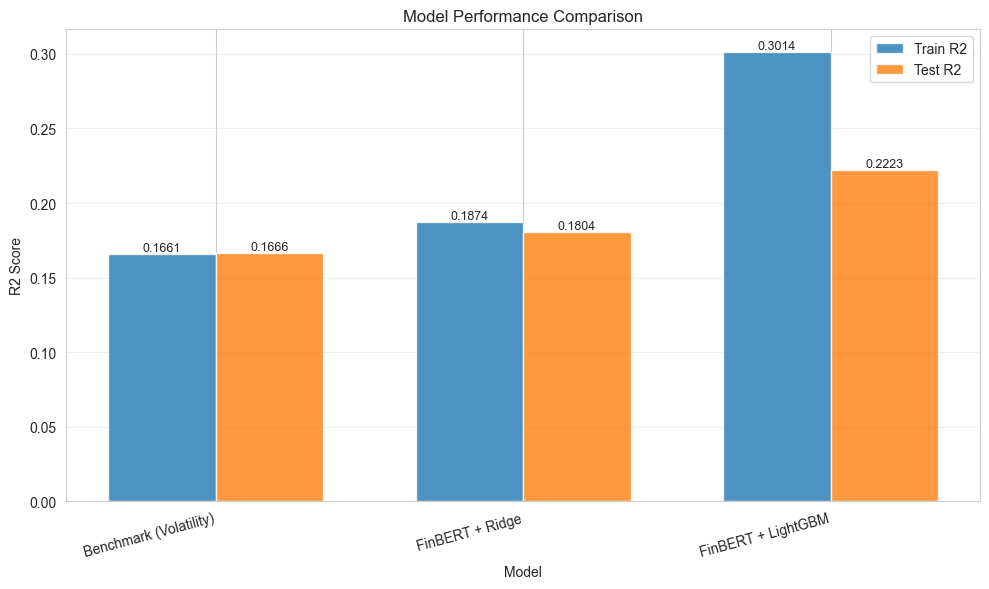

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

models = comparison_df["Model"].tolist()
train_r2 = comparison_df["Train R2"].tolist()
test_r2 = comparison_df["Test R2"].tolist()

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_r2, width, label="Train R2", alpha=0.8)
bars2 = ax.bar(x + width/2, test_r2, width, label="Test R2", alpha=0.8)

ax.set_xlabel("Model")
ax.set_ylabel("R2 Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha="right")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

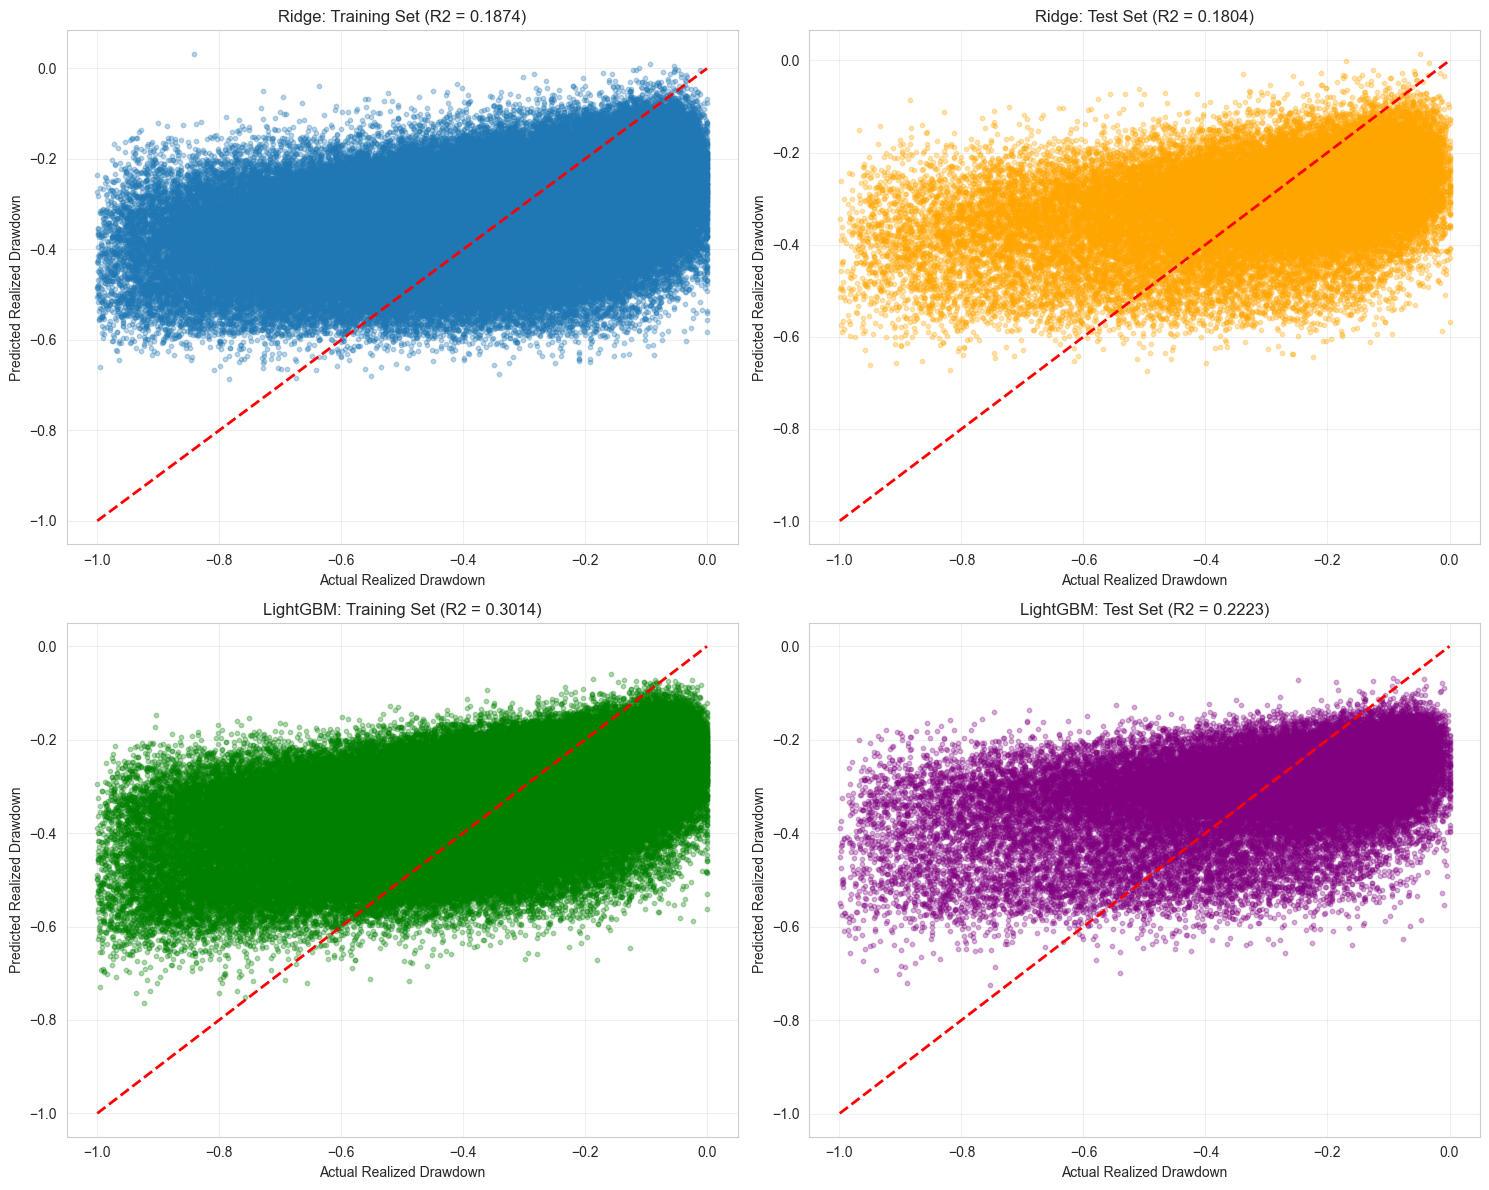

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Ridge - Training
axes[0, 0].scatter(y_train, y_train_pred_ridge, alpha=0.3, s=10)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
axes[0, 0].set_xlabel("Actual Realized Drawdown")
axes[0, 0].set_ylabel("Predicted Realized Drawdown")
axes[0, 0].set_title(f"Ridge: Training Set (R2 = {ridge_train_r2:.4f})")
axes[0, 0].grid(True, alpha=0.3)

# Ridge - Test
axes[0, 1].scatter(y_test, y_test_pred_ridge, alpha=0.3, s=10, color="orange")
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel("Actual Realized Drawdown")
axes[0, 1].set_ylabel("Predicted Realized Drawdown")
axes[0, 1].set_title(f"Ridge: Test Set (R2 = {ridge_test_r2:.4f})")
axes[0, 1].grid(True, alpha=0.3)

# LightGBM - Training
axes[1, 0].scatter(y_train, y_train_pred_lgb, alpha=0.3, s=10, color="green")
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
axes[1, 0].set_xlabel("Actual Realized Drawdown")
axes[1, 0].set_ylabel("Predicted Realized Drawdown")
axes[1, 0].set_title(f"LightGBM: Training Set (R2 = {lgb_train_r2:.4f})")
axes[1, 0].grid(True, alpha=0.3)

# LightGBM - Test
axes[1, 1].scatter(y_test, y_test_pred_lgb, alpha=0.3, s=10, color="purple")
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1, 1].set_xlabel("Actual Realized Drawdown")
axes[1, 1].set_ylabel("Predicted Realized Drawdown")
axes[1, 1].set_title(f"LightGBM: Test Set (R2 = {lgb_test_r2:.4f})")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis (LightGBM)

Examine which embedding dimensions are most important for prediction.

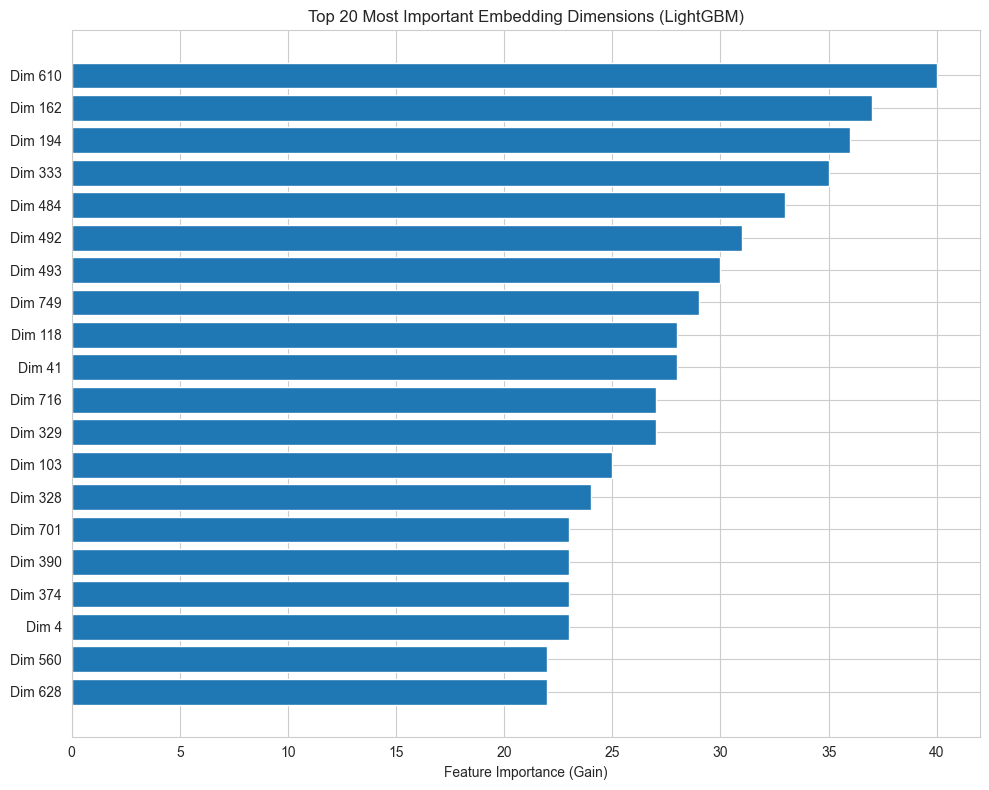


Top 20 most important embedding dimensions:
 1. Dimension 610: 40.0000
 2. Dimension 162: 37.0000
 3. Dimension 194: 36.0000
 4. Dimension 333: 35.0000
 5. Dimension 484: 33.0000
 6. Dimension 492: 31.0000
 7. Dimension 493: 30.0000
 8. Dimension 749: 29.0000
 9. Dimension 118: 28.0000
10. Dimension  41: 28.0000
11. Dimension 716: 27.0000
12. Dimension 329: 27.0000
13. Dimension 103: 25.0000
14. Dimension 328: 24.0000
15. Dimension 701: 23.0000
16. Dimension 390: 23.0000
17. Dimension 374: 23.0000
18. Dimension   4: 23.0000
19. Dimension 560: 22.0000
20. Dimension 628: 22.0000


In [ ]:
feature_importance = best_lgb.feature_importances_
top_k = 20
top_indices = np.argsort(feature_importance)[-top_k:][::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(top_k), feature_importance[top_indices])
plt.yticks(range(top_k), [f'Dim {i}' for i in top_indices])
plt.xlabel('Feature Importance (Gain)')
plt.title(f'Top {top_k} Most Important Embedding Dimensions (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop {top_k} most important embedding dimensions:")
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank:2d}. Dimension {idx:3d}: {feature_importance[idx]:.4f}")

## 9. Save Trained Models

Pickle all trained models, scaler, and embeddings for future use.

In [ ]:
from constants import PROJECT_ROOT
models_dir = os.path.join(PROJECT_ROOT, "trained_models")
os.makedirs(models_dir, exist_ok=True)

print(f"Saving models to: {models_dir}")

with open(os.path.join(models_dir, "finbert_ridge_model.pkl"), "wb") as f:
    pickle.dump(best_ridge, f)
print(" Saved: finbert_ridge_model.pkl")

with open(os.path.join(models_dir, "finbert_lightgbm_model.pkl"), "wb") as f:
    pickle.dump(best_lgb, f)
print(" Saved: finbert_lightgbm_model.pkl")

with open(os.path.join(models_dir, "embedding_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
print(" Saved: embedding_scaler.pkl")

np.save(os.path.join(models_dir, "train_embeddings.npy"), X_train_embeddings)
np.save(os.path.join(models_dir, "test_embeddings.npy"), X_test_embeddings)
print(" Saved: train_embeddings.npy and test_embeddings.npy")

np.save(os.path.join(models_dir, "train_indices.npy"), train_idx)
np.save(os.path.join(models_dir, "test_indices.npy"), test_idx)
print(" Saved: train_indices.npy and test_indices.npy")

comparison_df.to_csv(os.path.join(models_dir, "model_comparison.csv"), index=False)
print(" Saved: model_comparison.csv")

print()
print("All models and artifacts saved successfully!")

Saving models to: ./..\trained_models
 Saved: finbert_ridge_model.pkl
 Saved: finbert_lightgbm_model.pkl
 Saved: embedding_scaler.pkl
 Saved: train_embeddings.npy and test_embeddings.npy
 Saved: train_indices.npy and test_indices.npy
 Saved: model_comparison.csv

All models and artifacts saved successfully!
 Saved: train_embeddings.npy and test_embeddings.npy
 Saved: train_indices.npy and test_indices.npy
 Saved: model_comparison.csv

All models and artifacts saved successfully!


## 10. Key Findings

### Summary

This analysis demonstrates whether textual disclosures from corporate filings contain predictive information about downside risk beyond what historical volatility alone captures.

**Key Takeaways:**

1. **Benchmark Performance**: Historical volatility alone explains ~16.6% of variance in realized drawdown (R2 ≈ 0.166)

2. **Text Enhancement**: FinBERT embeddings allow models to capture information from risk factor disclosures that quantitative volatility metrics miss

3. **Linear vs Non-Linear**: 
   - Ridge Regression assumes linear relationships between embedding dimensions and drawdown
   - LightGBM can capture complex non-linear patterns and interactions